## My implementation of MINST 

In [51]:
%matplotlib inline
import torch.nn as nn            # containing various building blocks for your neural networks
import torch.optim as optim      # implementing various optimization algorithms
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
import torch

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
# transforms: transformations useful for image processing
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import glob
import os.path as osp
import numpy as np
from PIL import Image
import pdb
import sys

### Collecting the data

In [3]:
!wget https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true

--2019-10-09 20:44:29--  https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz [following]
--2019-10-09 20:44:30--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2019-10-09 20:44:30--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request

In [2]:
!ls

 Basic-image-reading.ipynb   mnist_png	        myMNIST.ipynb
'Basic pytorch.ipynb'	     mnist_png.tar.gz


In [3]:
!mv mnist_png.tar.gz\?raw\=true mnist_png.tar.gz

mv: cannot stat 'mnist_png.tar.gz?raw=true': No such file or directory


In [4]:
!tar -xzf mnist_png.tar.gz

In [5]:
!ls

 Basic-image-reading.ipynb   mnist_png	        myMNIST.ipynb
'Basic pytorch.ipynb'	     mnist_png.tar.gz


In [6]:
!ls mnist_png/training/

0  1  2  3  4  5  6  7	8  9


In [7]:
!ls mnist_png/testing/

0  1  2  3  4  5  6  7	8  9


### Create class that manupulates the data

In [39]:
class myMNIST(Dataset):
    """
    My version of customized MNIST dataset
    contains the following methods
    __getitem__
    __len__
    _preload
    """
    def __init__(self, rootpath, transform=None, preload=False):
        """
        Constructor for the class.
        ---
        Arguments:
        rootpath - path for the data to load, must contain subfolders with names from 0 to 9
        You can download a dataset like the following:
        wget https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true
        mv mnist_png.tar.gz\?raw\=true mnist_png.tar.gz
        tar -xzf mnist_png.tar.gz
        
        transform - transform to apply to the data
        preload - preload data to memory
        """
        self.images = None # list to hold the images if preloaded
        self.labels = None # list to hold labels if preloaded
        self.root = rootpath
        self.transform = transform
        self.filenames = [] # list to hold pairs (filename, digit_label)
        self.len = None
        
        #read filenames
        for digit in range(10): # for all the digits read corresponding files from the folder and create a pair (filename, digit)
            filenames = glob.glob(osp.join(self.root, str(digit), '*.png')) # read filenames
            filenames_and_labels = list(map(lambda filename: (filename,digit), filenames)) # add a label to each filename
            self.filenames += filenames_and_labels # append a digit data to an object 
        
        # preload the data
        if preload :
            self._preload()
        
        # set the len property
        self.len = len(self.filenames)
        
    def _preload(self):
        """
        Preload dataset into the memory.
        """
        self.images = []
        self.labels = []
        for file_name, label in self.filenames:
            tmp_image = Image.open(file_name)
            self.images.append(tmp_image.copy())
            self.labels.append(label)
            tmp_image.close()
    
    def __getitem__(self, index):
        """
        return an item with the specified index
        """
        try: 
            if self.images is not None: # images are preloaded
                image, label = self.images[index], self.labels[index]
            else:
                image_fn, label = self.filenames[index]
                image = Image.open(image_fn)

            # do the transform
            image = image if self.transform is None else self.transform(image)
        except IndexError:
            print("index out of range")
            image, label = None, None
        finally:
            return(image,label)
    
    def __len__(self):
        return(self.len)
    

In [40]:
%%time
MNISTData =  myMNIST(osp.join('mnist_png', 'training'),
                     transform=None,
                     preload=True)

CPU times: user 4.36 s, sys: 363 ms, total: 4.73 s
Wall time: 4.74 s


In [41]:
MNISTData.filenames[:10]

[('mnist_png/training/0/38315.png', 0),
 ('mnist_png/training/0/46294.png', 0),
 ('mnist_png/training/0/29497.png', 0),
 ('mnist_png/training/0/10859.png', 0),
 ('mnist_png/training/0/43418.png', 0),
 ('mnist_png/training/0/19664.png', 0),
 ('mnist_png/training/0/787.png', 0),
 ('mnist_png/training/0/54004.png', 0),
 ('mnist_png/training/0/57161.png', 0),
 ('mnist_png/training/0/10276.png', 0)]

In [42]:
testMNIST = myMNIST('mnist_png/training/',
                    transform=transforms.ToTensor(), 
                    preload=False)
#testMNIST = myMNIST('mnist_png/training/', preload=False)

In [43]:
im, lbl = testMNIST[33333]

In [44]:
im.size()

torch.Size([1, 28, 28])

In [54]:
transforms.ToPILImage()(im)

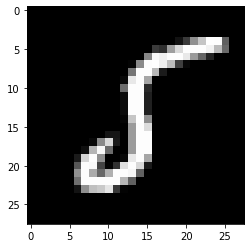

In [57]:
plt.imshow(transforms.ToPILImage()(im), cmap='gray')

In [9]:
im[0,8:17,8:17]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4588, 0.9922, 0.9922, 0.7216],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0353, 0.9098, 0.9922, 0.6510, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4235, 0.9922, 0.9922, 0.1647, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.9922, 0.9922, 0.1294, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.9922, 0.9922, 0.1294, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.9922, 0.9922, 0.1294, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.7765, 1.0000, 0.5608, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6078, 0.9922, 0.8627, 0.0000],
        [0.0000, 0.0000, 0.0863, 0.0863, 0.0000, 0.6078, 0.9922, 0.9922, 0.0000]])

In [10]:
len(testMNIST)

60000

In [11]:
del(MNISTData)
del(testMNIST)

### Create class that processed MNIST Dataset in batches

In [12]:
NUM_WORKERS = 1 if sys.platform == 'windows' else 4
NUM_WORKERS

4

#### Create two datasets for train and test

In [64]:
!ls mnist_png/

testing  training


In [14]:
trainMNIST = myMNIST(rootpath=osp.join('mnist_png','training'), 
                     transform=transforms.ToTensor(), 
                     preload=True)
testMNIST = myMNIST(rootpath=osp.join('mnist_png','testing'), 
                     transform=transforms.ToTensor(), 
                     preload=True)

#### Create two corresponding data loaders

In [77]:
trainLoader = DataLoader(dataset = trainMNIST, batch_size = 256, shuffle=True, num_workers=NUM_WORKERS)
testLoader = DataLoader(dataset = testMNIST, batch_size = 1000, shuffle=False, num_workers=NUM_WORKERS)

In [27]:
print(len(trainMNIST))

60000


In [28]:
print(len(testMNIST))

10000


In [25]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Display some images

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

    8     0     0     3     7     2     8     9     4     5     4     0     3     2     9     0


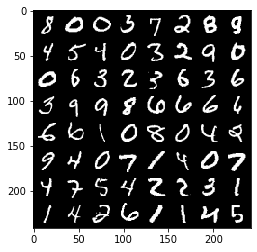

In [93]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainLoader)
images, labels = dataiter.next()

# show images
image_grid = torchvision.utils.make_grid(images[:64])
imshow(image_grid)
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(16)))

### Define a convolutional Network

In [ ]:
class myNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        #        dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        
        # Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.max_pool = nn.MaxPool2d(2)
        # ReLU(inplace=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Note: the following two ways for max pooling / relu are equivalent.
        # 1) with torch.nn.functional:
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # 2) with torch.nn:
        x = self.relu(self.max_pool(self.conv2_drop(self.conv2(x))))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [130]:
x = torch.ones(1,1,28,28)

In [120]:
conv1 = nn.Conv2d( 1,10, kernel_size=5)
conv2 = nn.Conv2d(10,20, kernel_size=5)
conv2_drop = nn.Dropout2d()
fc1 = nn.Linear(320, 50)
fc2 = nn.Linear(50, 10)

In [133]:
out1 = F.relu(F.max_pool2d(conv1(x),2))
out1.size()

torch.Size([1, 10, 12, 12])

In [134]:
out2 = F.relu(F.max_pool2d(conv2_drop(conv2(out1)), 2))

In [135]:
out2.size()

torch.Size([1, 20, 4, 4])

In [157]:
drop = nn.Dropout2d(p=0)
drop_input = torch.ones(2,3,2,2)
drop_input

tensor([[[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]],


        [[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]]])

In [158]:
drop_out = drop(drop_input)

In [159]:
drop_out

tensor([[[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]],


        [[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]]])

In [101]:
m = nn.Linear(2,5)
input  = torch.randn(10,2)

In [102]:
input

tensor([[-1.6184, -0.1538],
        [-0.7279, -1.2948],
        [-2.2174, -0.0344],
        [ 1.0340, -0.2797],
        [ 1.0660,  0.8330],
        [-0.1349, -0.3043],
        [ 2.7545, -0.1358],
        [-0.6227,  0.9750],
        [-0.8000,  0.7449],
        [ 0.9468, -0.6565]])

In [103]:
output = m(input)

In [104]:
output

tensor([[-0.9664, -0.7619,  0.4916,  0.0428,  1.3896],
        [-0.4291, -0.5122,  0.9616,  0.3005,  1.2062],
        [-1.2077, -1.0114,  0.4844,  0.0505,  1.7162],
        [ 0.0273,  0.3930,  0.3309, -0.1039, -0.1829],
        [-0.1672,  0.5469, -0.2024, -0.4171, -0.5513],
        [-0.3958, -0.1260,  0.4399, -0.0169,  0.5352],
        [ 0.6301,  1.1706,  0.1191, -0.2621, -1.2736],
        [-0.8114, -0.1807, -0.1297, -0.3409,  0.4305],
        [-0.8336, -0.2879, -0.0052, -0.2645,  0.6104],
        [ 0.0653,  0.3072,  0.5178,  0.0073, -0.0117]],
       grad_fn=<AddmmBackward>)

In [108]:
m.state_dict()

OrderedDict([('weight', tensor([[ 0.3658, -0.1854],
                      [ 0.4414,  0.1256],
                      [-0.0832, -0.4769],
                      [-0.0686, -0.2794],
                      [-0.6077, -0.3136]])),
             ('bias', tensor([-0.4028, -0.0283,  0.2835, -0.1112,  0.3578]))])

In [112]:
for param in m.parameters():
    print( param.data.T)

tensor([[ 0.3658,  0.4414, -0.0832, -0.0686, -0.6077],
        [-0.1854,  0.1256, -0.4769, -0.2794, -0.3136]])
tensor([-0.4028, -0.0283,  0.2835, -0.1112,  0.3578])
